In [62]:
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
sys.path.insert(0, "../../../")
from matplotlib.patches import Patch
from rnn_coach.src.utils import get_colormaps
colors, cmp = get_colormaps()
red, blue, bluish, green, orange, lblue, violet = colors
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_numpy import RNN_numpy
from rnn_coach.src.DynamicSystemAnalyzer import DynamicSystemAnalyzerCDDM
from copy import deepcopy
import pandas as pd
from pathlib import Path
import pickle
from tqdm.auto import tqdm

def plot_matrix(mat):
    names = ["ctx m", "ctx c", "mr", "ml", "cr", "cl", "OutR", "OutL"]
    n = 8
    fig, ax = plt.subplots(1, figsize = (12, 6))

    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(names)
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(names)

    # Set ticks on both sides of axes on
    # ax_w_rec_comparison[0].tick_params(axis="x", bottom=False, top=True, labelbottom=False, labeltop=True)
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    # Rotate and align bottom ticklabels
    plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="right", va="center", rotation_mode="anchor")
    # Rotate and align top ticklabels
    plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
             ha="left", va="center",rotation_mode="anchor")
    im_w_rec = ax.imshow(mat, interpolation='none', vmin=-np.max(np.abs(mat)), vmax = np.max(np.abs(mat)), cmap=cmp)

    for (i, j), z in np.ndenumerate(mat):
        if z != 0:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k', fontsize=12)
    fig.tight_layout()

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.68, 0.2, 0.02, 0.6])
    cbar = fig.colorbar(im_w_rec, cax=cbar_ax)
    # cbar.ax.set_ylabel('value', rotation=270, labelpad=10, fontsize=16)
    plt.subplots_adjust(wspace = 0.05)
    return fig

In [63]:
home = str(Path.home()) + "/Documents/GitHub/"
RNN = "0.0117232_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.5;lr=0.002;maxiter=3000"
RNNs_path = os.path.join(home, "latent_circuit_inference", "data", "inferred_LCs")
num_points = 31
offset = 5
RNN_score = float(RNN.split("_")[0])
RNN_path = os.path.join(RNNs_path, RNN)
LCs = os.listdir(RNN_path)
try:
    LCs.remove('.DS_Store')
except:
    pass
LC_scores = [float(LC.split("_")[0]) for LC in LCs]
LC_scores, LCs = zip(*sorted(zip(LC_scores, LCs), reverse=True))
top_LC = LCs[0]
# top_LC = LCs[np.argmax(np.array(LC_scores))]
# RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_{task_name}.json"), "rb+"))

In [64]:
RNN_data = json.load(open(os.path.join(RNN_path, top_LC, f"{RNN_score}_params_CDDM.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, top_LC, f"{RNN_score}_config.json"), "rb+"))
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]
dt = RNN_config_file["dt"]
tau = RNN_config_file["tau"]

# first plot correlation between the recovered matrices

In [75]:
LC_scores = [float(LC.split("_")[0]) for LC in LCs]
LC_scores, LCs = zip(*sorted(zip(LC_scores, LCs), reverse=True))
W_rec_pr_list = []
w_rec_list = []
Qs = []
for LC in tqdm(LCs):
    score = float(LC.split("_")[0])
    score_pr = float(LC.split("_")[1])
    with open(os.path.join(RNN_path, LC, f"{score}_{score_pr}_LC_params.json"), "rb+") as fd:
        LC_data = json.load(fd)
        U = np.array(LC_data["U"])
        q = np.array(LC_data["q"])
        Q = U.T @ q
        w_out = np.array(LC_data["W_out"])
        w_rec = np.array(LC_data["W_rec"])
        w_inp = np.array(LC_data["W_inp"])
        N = LC_data["N"]
        dt = LC_data["dt"]
        tau = LC_data["tau"]
        W_rec_pr = Q.T @ W_rec @ Q
        w_rec_list.append(deepcopy(w_rec))
        W_rec_pr_list.append(deepcopy(W_rec_pr))
        Qs.append(deepcopy(Q))
#         fd.close()

  0%|          | 0/43 [00:00<?, ?it/s]

0.25961484246676153


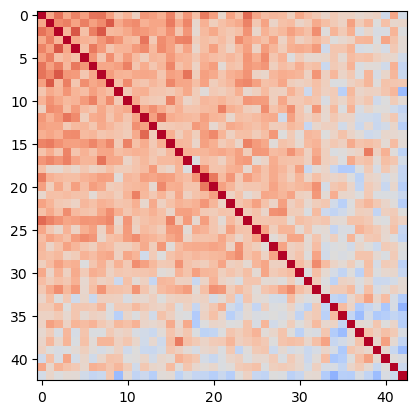

In [91]:
# check if the top ones correlate with one another
Qs_flattened = [Q.flatten()/np.linalg.norm(Q.flatten()) for Q in Qs]
Qs_flattened_array = np.array(Qs_flattened)
q_corr = Qs_flattened_array @ Qs_flattened_array.T
plt.imshow(q_corr, vmin=0, vmax = 1, cmap='coolwarm')
print(np.min(q_corr))

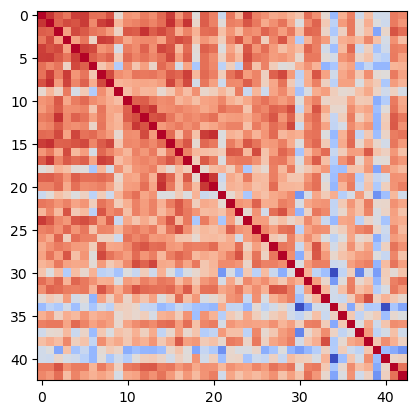

In [77]:
# check if the top ones correlate with one another
Ws_flattened = [W.flatten()/np.linalg.norm(W.flatten()) for W in W_rec_pr_list]
Ws_flattened_array = np.array(Ws_flattened)
W_corr = Ws_flattened_array @ Ws_flattened_array.T
plt.imshow(W_corr, vmin=np.min(W_corr), vmax = 1, cmap='coolwarm')

0.6731999820940074


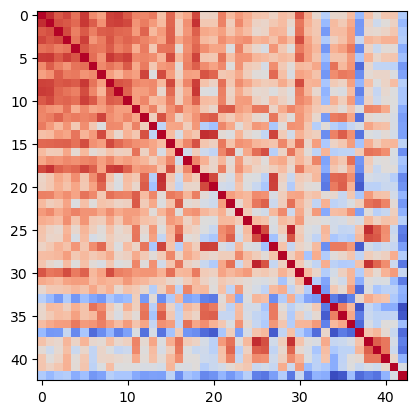

In [82]:
# check if the top ones correlate with one another
ws_flattened = [w.flatten()/np.linalg.norm(w.flatten()) for w in w_rec_list]
ws_flattened_array = np.array(ws_flattened)
w_corr = ws_flattened_array @ ws_flattened_array.T
plt.imshow(w_corr, vmin=np.min(w_corr), vmax = 1, cmap='coolwarm')

In [83]:
score = float(top_LC.split("_")[0])
score_pr = float(top_LC.split("_")[1])
LC_data = json.load(open(os.path.join(RNN_path, top_LC, f"{score}_{score_pr}_LC_params.json"), "rb+"))
U = np.array(LC_data["U"])
q = np.array(LC_data["q"])
Q = U.T @ q
w_out = np.array(LC_data["W_out"])
w_rec = np.array(LC_data["W_rec"])
w_inp = np.array(LC_data["W_inp"])
N = LC_data["N"]
dt = LC_data["dt"]
tau = LC_data["tau"]

# loading up the task
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)

# creating instances of lc and RNN
lc = RNN_numpy(N=8, dt=dt, tau=tau, W_inp=w_inp, W_rec=w_rec, W_out=w_out)
RNN = RNN_numpy(N=W_rec.shape[0], dt=1, tau=tau, W_inp=W_inp, W_rec=W_rec, W_out=W_out)

dsa_RNN = DynamicSystemAnalyzerCDDM(RNN)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 10,
          "patience": 10,
          "stop_length": 10,
          "mode": "approx"}

dsa_lc = DynamicSystemAnalyzerCDDM(lc)
params = {"fun_tol": 0.05,
          "diff_cutoff": 1e-4,
          "sigma_init_guess": 10,
          "patience": 10,
          "stop_length": 10,
          "mode": "approx"}

#instead of calculating, load it
# LA_data_RNN = pickle.load(open(os.path.join(RNNs_path, RNN_subfolder, f"{RNN_score}_LA_data.pkl"), "rb+"))
dsa_RNN.calc_LineAttractor_analytics(N_points=num_points)
dsa_lc.calc_LineAttractor_analytics(N_points=num_points)

Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in motion context...


  0%|          | 0/31 [00:00<?, ?it/s]

Analyzing points on a line attractor in color context...


  0%|          | 0/31 [00:00<?, ?it/s]

In [84]:
LA_data_lc = dsa_lc.LA_data
LA_data_RNN = dsa_RNN.LA_data

In [85]:
# selection vectors:
projected_l_RNN_motion = (np.array(LA_data_RNN["motion"]["l"][:-offset])) @ Q
avg_pr_l_RNN_motion = np.mean(projected_l_RNN_motion, axis=0).flatten()
avg_pr_l_RNN_motion = avg_pr_l_RNN_motion / np.linalg.norm(avg_pr_l_RNN_motion)
projected_l_circuit_motion = (np.array(LA_data_lc["motion"]["l"][offset:-offset]))
avg_pr_l_circuit_motion = np.mean(projected_l_circuit_motion, axis=0).flatten()
avg_pr_l_circuit_motion = avg_pr_l_circuit_motion / np.linalg.norm(avg_pr_l_circuit_motion)

projected_l_RNN_color = (np.array(LA_data_RNN["color"]["l"][offset:-offset])) @ Q
avg_pr_l_RNN_color = np.mean(projected_l_RNN_color, axis=0).flatten()
avg_pr_l_RNN_color = avg_pr_l_RNN_color / np.linalg.norm(avg_pr_l_RNN_color)
projected_l_circuit_color = (np.array(LA_data_lc["color"]["l"][offset:-offset]))
avg_pr_l_circuit_color = np.mean(projected_l_circuit_color, axis=0).flatten()
avg_pr_l_circuit_color = avg_pr_l_circuit_color / np.linalg.norm(avg_pr_l_circuit_color)

# Jacobians
Js_motion = LA_data_RNN["motion"]["jac"][offset:-offset]
js_motion = LA_data_lc["motion"]["jac"][offset:-offset]
Js_color = LA_data_RNN["color"]["jac"][offset:-offset]
js_color = LA_data_lc["color"]["jac"][offset:-offset]

projected_Ws_motion_d = [Q.T @ (J + np.eye(J.shape[0])) @ Q for J in Js_motion]
ws_motion_d = [j + np.eye(8) for j in js_motion]
projected_W_motion = np.mean(np.array(projected_Ws_motion_d), axis=0)
#     projected_W_motion = np.array(projected_Ws_motion_d)[len(Js_motion)//2,:, :]
w_motion = np.mean(np.array(ws_motion_d), axis=0)
#     w_motion = np.array(ws_motion_d)[len(Js_motion)//2,:, :]

projected_Ws_color_d = [Q.T @ (J + np.eye(J.shape[0])) @ Q for J in Js_color]
ws_color_d = [j + np.eye(8) for j in js_color]
projected_W_color = np.mean(np.array(projected_Ws_color_d), axis=0)
#     projected_W_color = np.array(projected_Ws_color_d)[len(Js_motion)//2,:, :]
w_color = np.mean(np.array(ws_color_d), axis=0)
#     w_color = np.array(ws_color_d)[len(Js_motion)//2,:, :]

W_rec_pr = Q.T @ W_rec @ Q
w_rec = deepcopy(w_rec)
SV_motion = deepcopy(avg_pr_l_RNN_motion)
sv_motion = deepcopy(avg_pr_l_circuit_motion)
SV_color = deepcopy(avg_pr_l_RNN_color)
sv_color = deepcopy(avg_pr_l_circuit_color)

JAC_motion = deepcopy(projected_W_motion)
jac_motion = deepcopy(w_motion)
JAC_color = deepcopy(projected_W_color)
jac_color = deepcopy(w_color)

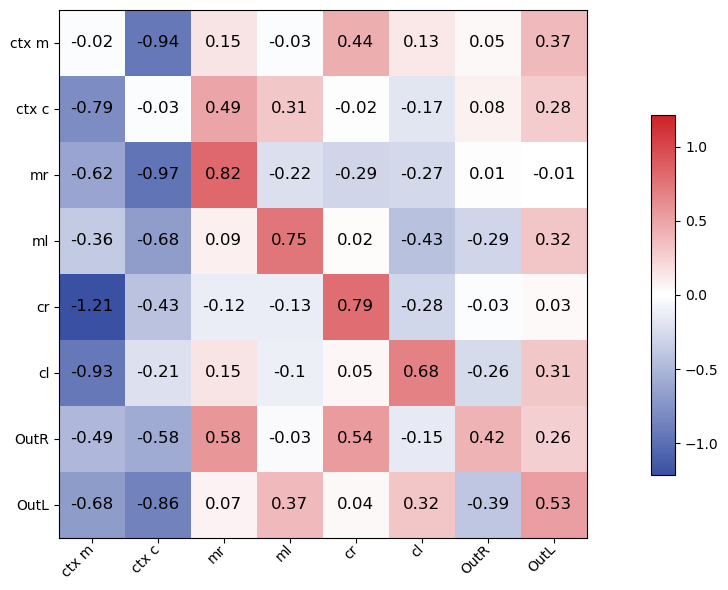

In [86]:
W_rec_pr_img = plot_matrix(W_rec_pr)
plt.show()

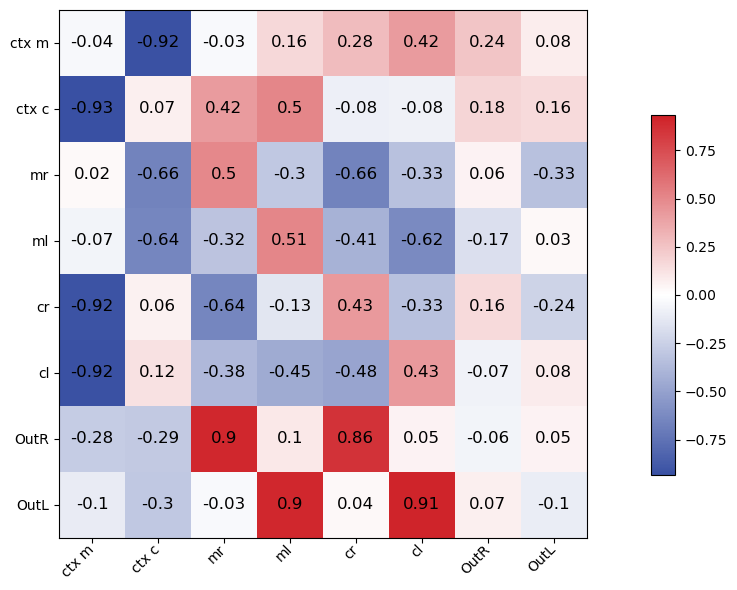

In [87]:
w_rec_img = plot_matrix(w_rec)
plt.show()

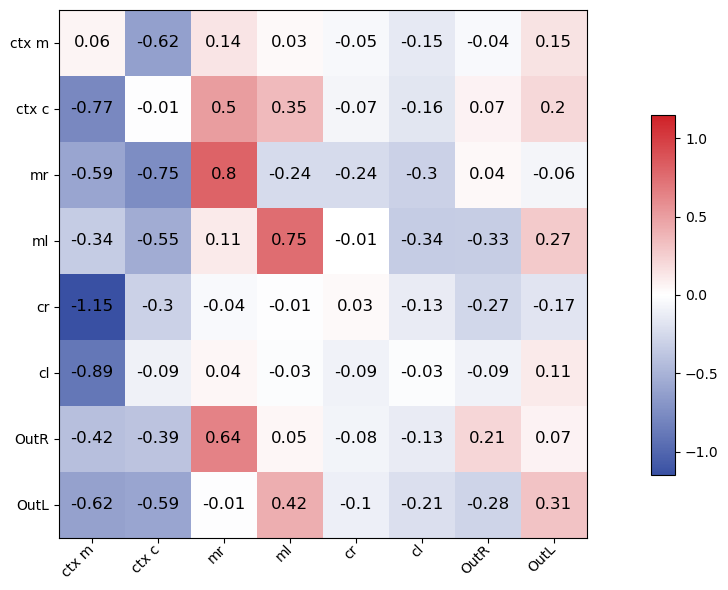

In [92]:
JAC_motion_img = plot_matrix(JAC_motion)
plt.show()

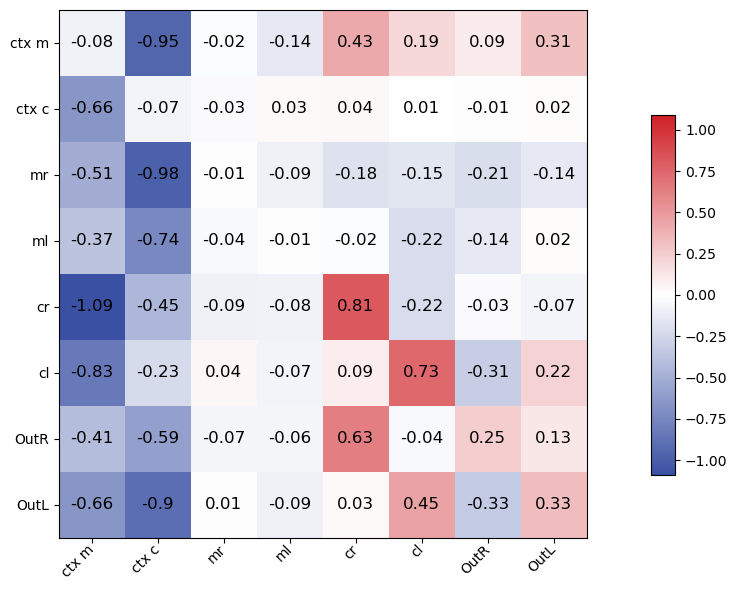

In [89]:
JAC_color_img = plot_matrix(JAC_color)
plt.show()